In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D

In [3]:
# Metadata saved to output plots
METADATA = {"Contributor": "Alexander Gude", "Rights": "CC-BY-SA 4.0"}

In [4]:
# Show plots inline
%matplotlib inline

In [5]:
COLORS = {
    "zillow": "#006AFF",
    "redfin": "#E62E2E",
    "xome": "#FF5C39",
    "realtor.com": "#D92228",
}

# Helper functions

In [6]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.


def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.

    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.

    Returns:
        (fig, ax): A Matplotlib figure and axis object.

    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    # Figure output
    plt.rcParams["savefig.dpi"] = 300

    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Make the title and label area opaque instead of transparent
    fig.patch.set_facecolor(ax.get_facecolor())

    return fig, ax

In [7]:
def draw_colored_legend(ax):
    """Draw a legend for the plot with the text colored to match the points.

    Args:
        ax (matplotlib axis): The axis to draw on.

    """
    # Draw a legend where there is no space around the line/point so
    # that the text is in the right place when we turn off the line/point.
    legend = ax.legend(handlelength=0, handletextpad=0)

    handles = legend.legendHandles
    texts = legend.get_texts()
    for handle, text in zip(handles, texts):
        # Change the color of the text to match the line or points
        try:
            # Points and some other objects have this
            color = handle.get_facecolor()[0]
        except AttributeError:
            # Lines have this
            color = handle.get_color()

        text.set_color(color)

        # Turn off the point
        handle.set_visible(False)

In [8]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.

    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.

    """
    metadata = METADATA

    fig.savefig(
        fname=f"{filename}",
        bbox_inches="tight",
        metadata=metadata,
    )

In [9]:
def number_formatter(number, pos=None):
    """Convert a number into a human readable format.

    Via https://flynn.gg/blog/better-matplotlib-charts/"""
    number /= 1000.0

    return f"${number:,.0f}K"

# Data

In [10]:
df = pd.read_csv("./data.csv", header=0, index_col="company").sort_values(
    "pre_estimate"
)

df

,pre_estimate,pre_low,pre_high,post_estimate,post_sale_estimate,post_sale_low,post_sale_high
company,,,,,,,
zillow,938000,NaN,NaN,941000.0,1077400.0,NaN,NaN
actual,948500,NaN,NaN,1070000.0,NaN,NaN,NaN
realtor.com,977100,NaN,NaN,NaN,1105000.0,NaN,NaN
xome,1040140,949000.0,1130000.0,NaN,1074820.0,961337.0,1165355.0
redfin,1144535,NaN,NaN,962551.0,1090365.0,NaN,NaN


In [11]:
list_price = df.loc["actual", "pre_estimate"].item()
sold_price = df.loc["actual", "post_estimate"].item()

In [12]:
companies_df = df.drop("actual")

In [13]:
company_names = [c.capitalize() for c in companies_df.index]

In [14]:
color_list = [COLORS.get(company.lower()) for company in company_names]

In [15]:
pre_estimates = companies_df["pre_estimate"].values
post_estimates = companies_df["post_estimate"].values
post_sale_estimates = companies_df["post_sale_estimate"].values

In [16]:
y_errors = [
    pre_estimates - companies_df["pre_low"].values,
    companies_df["pre_high"].values - pre_estimates,
]

y_errors_post_sale = [
    post_sale_estimates - companies_df["post_sale_low"].values,
    companies_df["post_sale_high"].values - post_sale_estimates,
]

# Plotting

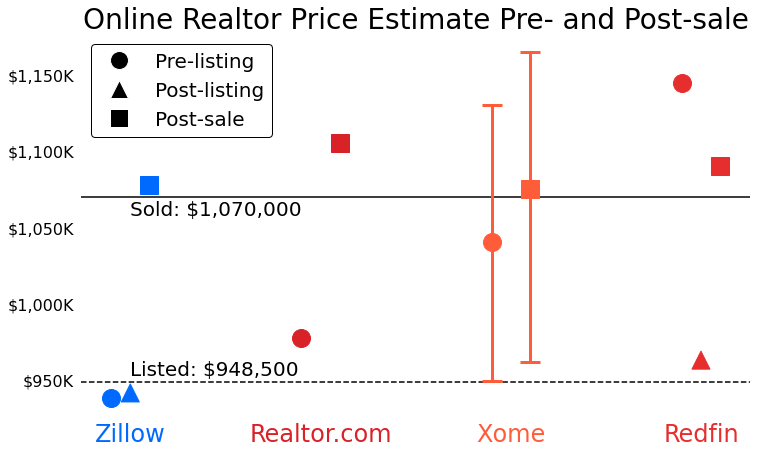

In [17]:
fig, ax = setup_plot("Online Realtor Price Estimate Pre- and Post-sale")

# Format y-axis for dollars
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Scatter plot uses a different size that is the square of the marker size
marker_size = 18
scatter_size = marker_size ** 2
pre_list_marker = "o"
post_list_marker = "^"
post_sale_marker = "s"


# Plot estimates

# Use affine2d to push the values over slightly to avoid overlap
shift_left = Affine2D().translate(-0.1, 0.0) + ax.transData

# For errorbar, the best way to match the color is to do a for loop, unfortunately.
# See: https://stackoverflow.com/a/21915157/1342354
for x, y, color, y_low, y_high in zip(
    company_names, pre_estimates, color_list, y_errors[0], y_errors[1]
):
    yerr = [[y_low], [y_high]]
    ax.errorbar(
        x=x,
        y=y,
        yerr=yerr,
        markersize=marker_size,
        c=color,
        label="Pre-Listing Estimate",
        capsize=10,
        capthick=3,
        elinewidth=3,
        fmt=pre_list_marker,
        transform=shift_left,
    )

ax.scatter(
    x=company_names,
    y=post_estimates,
    color=color_list,
    s=scatter_size,
    label="Post-Listing Estimate",
    marker=post_list_marker,
)

shift_right = Affine2D().translate(0.1, 0.0) + ax.transData
for x, y, color, y_low, y_high in zip(
    company_names,
    post_sale_estimates,
    color_list,
    y_errors_post_sale[0],
    y_errors_post_sale[1],
):
    yerr = [[y_low], [y_high]]
    ax.errorbar(
        x=x,
        y=y,
        yerr=yerr,
        markersize=marker_size,
        c=color,
        label="Post-sale Estimate",
        capsize=10,
        capthick=3,
        elinewidth=3,
        fmt=post_sale_marker,
        transform=shift_right,
    )

# Draw list and sales prices
ax.axhline(y=list_price, color="black", zorder=1, linestyle="dashed")
ax.axhline(y=sold_price, color="black", zorder=1)

ax.text(x="Zillow", y=list_price + 4500, s=f"Listed: ${list_price:,.0f}", fontsize=20)
ax.text(x="Zillow", y=sold_price - 12000, s=f"Sold: ${sold_price:,.0f}", fontsize=20)

# Build a custom legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker=pre_list_marker,
        color="w",  # remove line by setting color to white
        label="Pre-listing",
        markerfacecolor="black",
        markersize=marker_size,
    ),
    Line2D(
        [0],
        [0],
        marker=post_list_marker,
        color="w",
        label="Post-listing",
        markerfacecolor="black",
        markersize=marker_size,
    ),
    Line2D(
        [0],
        [0],
        marker=post_sale_marker,
        color="w",
        label="Post-sale",
        markerfacecolor="black",
        markersize=marker_size,
    ),
]

ax.legend(handles=legend_elements, loc="upper left")

# Adjust x-axis labels
ax.xaxis.set_ticks_position("none")  # Remove the line from ticks
ax.yaxis.set_ticks_position("none")

for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(color_list[i])

ax.tick_params(axis="x", labelsize=24)

sns.despine(top=True, bottom=True, left=True, right=True)


for ext in ("png", "svg"):
    save_plot(fig, f"/tmp/home_price_estimate_comparison.{ext}")